# 03 – BERT Fine-Tuning (BBC News)

Ziel: Fine-Tuning eines vortrainierten Transformer-Modells (BERT) für Textklassifikation und Vergleich gegen die Baseline.


In [15]:
import time
import random
import numpy as np
import pandas as pd
from pathlib import Path

import torch

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


Seeds

In [16]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))


CUDA available: True
Device: cuda


## 1) CSV laden & Labels encoden


In [17]:
PROJECT_ROOT = Path.cwd().parent
CSV_PATH = PROJECT_ROOT / "data" / "processed" / "bbc_news.csv"

df = pd.read_csv(CSV_PATH, encoding="utf-8")
df.shape, df["label"].nunique()


((2225, 5), 5)

In [18]:
labels_sorted = sorted(df["label"].unique())
label2id = {lbl: i for i, lbl in enumerate(labels_sorted)}
id2label = {i: lbl for lbl, i in label2id.items()}

df["label_id"] = df["label"].map(label2id)

labels_sorted, label2id


(['business', 'entertainment', 'politics', 'sport', 'tech'],
 {'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4})

## 2) Train/Validation/Test Split


In [19]:
X = df["text"].tolist()
y = df["label_id"].tolist()

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp
)

print("Train:", len(X_train), "Val:", len(X_val), "Test:", len(X_test))


Train: 1780 Val: 222 Test: 223


## 3) Tokenization + Dataset


In [20]:
MODEL_NAME = "bert-base-uncased"
# Alternative später: "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Tokenize Function

In [21]:
MAX_LEN = 256  # 256 ist oft ein guter Tradeoff bei News-Texten

def tokenize_texts(texts):
    return tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=MAX_LEN
    )


Torch Dataset

In [22]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenize_texts(texts)
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_ds = TextDataset(X_train, y_train)
val_ds   = TextDataset(X_val, y_val)
test_ds  = TextDataset(X_test, y_test)

len(train_ds), len(val_ds), len(test_ds)


(1780, 222, 223)

## 4) Model + Training


Model

In [23]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(labels_sorted),
    id2label=id2label,
    label2id=label2id
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Metrics

In [24]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, preds)}


Training Arguments (bei genügend GPU batch 16 ok, sonst 8 (bei out of memory))

In [25]:
OUT_DIR = PROJECT_ROOT / "results" / "bert"
OUT_DIR.mkdir(parents=True, exist_ok=True)

training_args = TrainingArguments(
    output_dir=str(OUT_DIR),
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",
    seed=SEED
)


c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Trainer und Train (mit Zeitmessung)

In [26]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

start = time.time()
train_output = trainer.train()
elapsed = time.time() - start

print(f"Training time: {elapsed/60:.1f} minutes")
train_output


  0%|          | 0/336 [00:00<?, ?it/s]

{'loss': 1.1581, 'grad_norm': 6.746057987213135, 'learning_rate': 1.7023809523809524e-05, 'epoch': 0.45}
{'loss': 0.3406, 'grad_norm': 6.959774971008301, 'learning_rate': 1.4047619047619048e-05, 'epoch': 0.89}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.13826018571853638, 'eval_accuracy': 0.972972972972973, 'eval_runtime': 0.5065, 'eval_samples_per_second': 438.282, 'eval_steps_per_second': 13.82, 'epoch': 1.0}
{'loss': 0.1265, 'grad_norm': 0.5233879089355469, 'learning_rate': 1.1071428571428572e-05, 'epoch': 1.34}
{'loss': 0.0631, 'grad_norm': 0.1538938730955124, 'learning_rate': 8.095238095238097e-06, 'epoch': 1.79}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.054659731686115265, 'eval_accuracy': 0.9864864864864865, 'eval_runtime': 0.5012, 'eval_samples_per_second': 442.925, 'eval_steps_per_second': 13.966, 'epoch': 2.0}
{'loss': 0.0607, 'grad_norm': 0.2029930055141449, 'learning_rate': 5.119047619047619e-06, 'epoch': 2.23}
{'loss': 0.0346, 'grad_norm': 0.30953291058540344, 'learning_rate': 2.1428571428571427e-06, 'epoch': 2.68}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.04244857653975487, 'eval_accuracy': 0.9864864864864865, 'eval_runtime': 0.4901, 'eval_samples_per_second': 452.934, 'eval_steps_per_second': 14.282, 'epoch': 3.0}
{'train_runtime': 46.2584, 'train_samples_per_second': 115.439, 'train_steps_per_second': 7.264, 'train_loss': 0.2684259755270822, 'epoch': 3.0}
Training time: 0.8 minutes


TrainOutput(global_step=336, training_loss=0.2684259755270822, metrics={'train_runtime': 46.2584, 'train_samples_per_second': 115.439, 'train_steps_per_second': 7.264, 'total_flos': 702525440378880.0, 'train_loss': 0.2684259755270822, 'epoch': 3.0})

## 5) Evaluation auf Testset + Report


Predict Test

In [27]:
pred = trainer.predict(test_ds)
test_logits = pred.predictions
test_labels = pred.label_ids
test_preds = np.argmax(test_logits, axis=-1)

print("Test Accuracy:", accuracy_score(test_labels, test_preds))
print("\nClassification Report:\n")
print(classification_report(
    test_labels,
    test_preds,
    target_names=[id2label[i] for i in range(len(labels_sorted))]
))


  0%|          | 0/7 [00:00<?, ?it/s]

Test Accuracy: 0.9820627802690582

Classification Report:

               precision    recall  f1-score   support

     business       1.00      0.92      0.96        51
entertainment       1.00      1.00      1.00        39
     politics       0.93      1.00      0.97        42
        sport       1.00      1.00      1.00        51
         tech       0.98      1.00      0.99        40

     accuracy                           0.98       223
    macro avg       0.98      0.98      0.98       223
 weighted avg       0.98      0.98      0.98       223



## 6) Confusion Matrix (schön plotten)


Saved: c:\CAS\cas-ml-document-classification\results\bert\confusion_matrix_bert-base-uncased.png


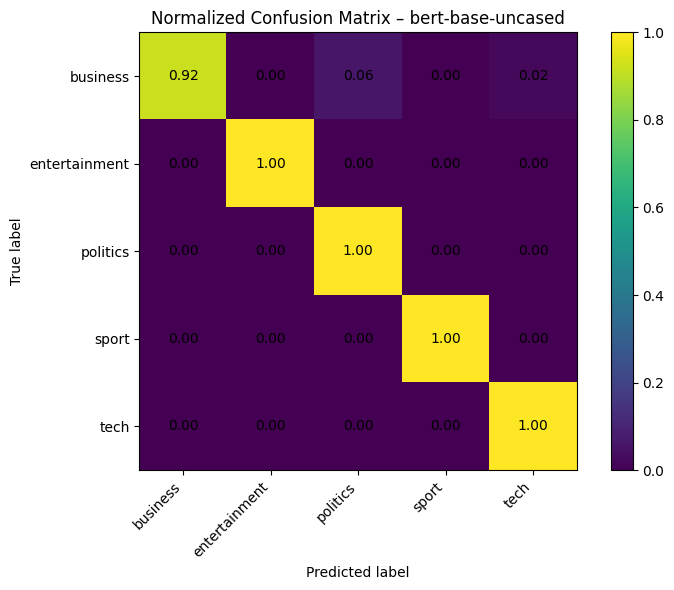

In [28]:
import matplotlib.pyplot as plt

cm = confusion_matrix(test_labels, test_preds, labels=list(range(len(labels_sorted))))
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm_norm)

ax.set_xticks(np.arange(len(labels_sorted)))
ax.set_yticks(np.arange(len(labels_sorted)))
ax.set_xticklabels([id2label[i] for i in range(len(labels_sorted))], rotation=45, ha="right")
ax.set_yticklabels([id2label[i] for i in range(len(labels_sorted))])

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title(f"Normalized Confusion Matrix – {MODEL_NAME}")

# Zahlen in die Zellen
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        ax.text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center")

fig.colorbar(im, ax=ax)
fig.tight_layout()

fig_path = OUT_DIR / f"confusion_matrix_{MODEL_NAME.replace('/', '_')}.png"
fig.savefig(fig_path, dpi=300)
print("Saved:", fig_path)

plt.show()


## 7) Model speichern + Predictions exportieren (für Nachvollziehbarkeit)


In [29]:
model_dir = OUT_DIR / "best_model"
trainer.save_model(str(model_dir))
tokenizer.save_pretrained(str(model_dir))

print("Saved model to:", model_dir)


Saved model to: c:\CAS\cas-ml-document-classification\results\bert\best_model


Predictions CSV (für spätere Error Analysis)

In [30]:
pred_df = pd.DataFrame({
    "true_id": test_labels,
    "pred_id": test_preds,
    "true_label": [id2label[i] for i in test_labels],
    "pred_label": [id2label[i] for i in test_preds],
    "text": X_test
})

pred_csv = OUT_DIR / "test_predictions.csv"
pred_df.to_csv(pred_csv, index=False, encoding="utf-8")
print("Saved:", pred_csv)

pred_df[pred_df["true_id"] != pred_df["pred_id"]].head(10)


Saved: c:\CAS\cas-ml-document-classification\results\bert\test_predictions.csv


,true_id,pred_id,true_label,pred_label,text
43,0,4,business,tech,BT offers equal access to rivals\n\nBT has mov...
152,0,2,business,politics,Golden rule 'intact' says ex-aide\n\nChancello...
191,0,2,business,politics,US bank boss hails 'genius' Smith\n\nUS Federa...
215,0,2,business,politics,Aids and climate top Davos agenda\n\nClimate c...
